# HuggingFace Hub meets Amazon SageMaker
### Fine-tune a Multi-Class Classification with `Trainer` and `emotion` dataset and push it to the [Hugging Face Hub](https://huggingface.co/models)

# Introduction

Welcome to our end-to-end multi-class Text-Classification example. In this demo, we will use the Hugging Faces `transformers` and `datasets` library together with a custom Amazon sagemaker-sdk extension to fine-tune a pre-trained transformer for multi-class text classification. In particular, the pre-trained model will be fine-tuned using the `emotion` dataset. To get started, we need to set up the environment with a few prerequisite steps, for permissions, configurations, and so on. 

![emotion-widget.png](./imgs/emotion-widget.png)

_**NOTE: You can run this demo in Sagemaker Studio, your local machine or Sagemaker Notebook Instances**_
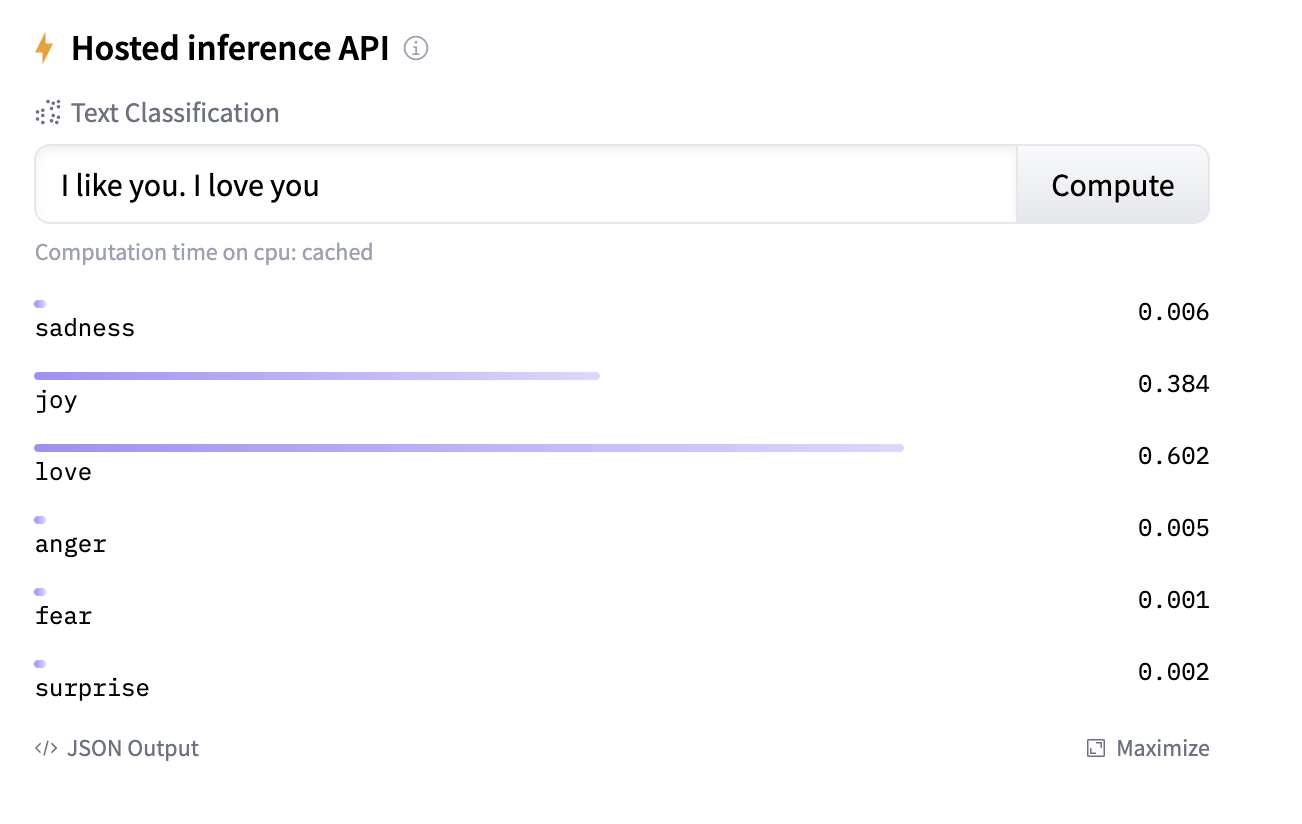

# Development Environment and Permissions 

## Installation

_*Note:* we only install the required libraries from Hugging Face and AWS. You also need PyTorch or Tensorflow, if you haven´t it installed_

In [ ]:
!pip install "sagemaker>=2.140.0" "transformers==4.26.1" "datasets[s3]==2.10.1" --upgrade

In [ ]:
import sagemaker.huggingface

## Permissions

_If you are going to use Sagemaker in a local environment. You need access to an IAM Role with the required permissions for Sagemaker. You can find [here](https://docs.aws.amazon.com/sagemaker/latest/dg/sagemaker-roles.html) more about it._

In [ ]:
import sagemaker
import boto3
sess = sagemaker.Session()
# sagemaker session bucket -> used for uploading data, models and logs
# sagemaker will automatically create this bucket if it not exists
sagemaker_session_bucket=None
if sagemaker_session_bucket is None and sess is not None:
    # set to default bucket if a bucket name is not given
    sagemaker_session_bucket = sess.default_bucket()

try:
    role = sagemaker.get_execution_role()
except ValueError:
    iam = boto3.client('iam')
    role = iam.get_role(RoleName='sagemaker_execution_role')['Role']['Arn']

sess = sagemaker.Session(default_bucket=sagemaker_session_bucket)

print(f"sagemaker role arn: {role}")
print(f"sagemaker bucket: {sess.default_bucket()}")
print(f"sagemaker session region: {sess.boto_region_name}")

# Preprocessing

We are using the `datasets` library to download and preprocess the `emotion` dataset. After preprocessing, the dataset will be uploaded to our `sagemaker_session_bucket` to be used within our training job. The [emotion](https://github.com/dair-ai/emotion_dataset) dataset consists of 16000 training examples, 2000 validation examples, and 2000 testing examples.

## Tokenization 

In [3]:
from datasets import load_dataset
from transformers import AutoTokenizer

# tokenizer used in preprocessing
tokenizer_name = 'distilbert-base-uncased'

# dataset used
dataset_name = 'emotion'

# s3 key prefix for the data
s3_prefix = 'samples/datasets/emotion'

In [4]:
# download tokenizer
tokenizer = AutoTokenizer.from_pretrained(tokenizer_name)

# tokenizer helper function
def tokenize(batch):
    return tokenizer(batch['text'], padding='max_length', truncation=True)

# load dataset
train_dataset, test_dataset = load_dataset(dataset_name, split=['train', 'test'])

# tokenize dataset
train_dataset = train_dataset.map(tokenize, batched=True)
test_dataset = test_dataset.map(tokenize, batched=True)

# set format for pytorch
train_dataset =  train_dataset.rename_column("label", "labels")
train_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])
test_dataset = test_dataset.rename_column("label", "labels")
test_dataset.set_format('torch', columns=['input_ids', 'attention_mask', 'labels'])

Downloading: 3.62kB [00:00, 629kB/s]                    
Downloading: 3.28kB [00:00, 998kB/s]                    
Using custom data configuration default
Reusing dataset emotion (/Users/philipp/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)
100%|██████████| 2/2 [00:00<00:00,  6.47ba/s]


## Uploading data to `sagemaker_session_bucket`

After we processed the `datasets` we are going to use the new `FileSystem` [integration](https://huggingface.co/docs/datasets/filesystems.html) to upload our dataset to S3.

In [5]:
# save train_dataset to s3
training_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/train'
train_dataset.save_to_disk(training_input_path)

# save test_dataset to s3
test_input_path = f's3://{sess.default_bucket()}/{s3_prefix}/test'
test_dataset.save_to_disk(test_input_path)

## Creating an Estimator and start a training job

List of supported models: https://huggingface.co/models?library=pytorch,transformers&sort=downloads

#### setting up `push_to_hub` for our model. 

The `train.py` scripts implements the `push_to_hub` using the `Trainer` and `TrainingArguments`. To push our model to the [Hub](https://huggingface.co/models) we need to define the `push_to_hub`. hyperparameter and set it to `True` and provide out [Hugging Face Token](https://hf.co/settings/token). Additionally, we can configure the repository name and saving strategy using the `hub_model_id`, `hub_strategy`.

You can find documentation to those parameters [here](https://huggingface.co/transformers/main_classes/trainer.html).

We are going to provide our HF Token securely with out exposing it to the public using `notebook_login` from the `huggingface_hub` SDK. 
But be careful your token will still be visible insight the logs of the training job. If you run `huggingface_estimator.fit(...,wait=True)` you will see the token in the logs.
A better way of providing your `HF_TOKEN` to your training jobs would be using [AWS Secret Manager](https://docs.aws.amazon.com/secretsmanager/latest/userguide/intro.html)

#### You can also directly find your token at [https://hf.co/settings/token](https://hf.co/settings/token).


In [17]:
from huggingface_hub import notebook_login

notebook_login()

In [2]:
from sagemaker.huggingface import HuggingFace
from huggingface_hub import HfFolder
import time

# hyperparameters, which are passed into the training job
hyperparameters={'epochs': 1,                                    # number of training epochs
                 'train_batch_size': 32,                         # batch size for training
                 'eval_batch_size': 64,                          # batch size for evaluation
                 'learning_rate': 3e-5,                          # learning rate used during training
                 'model_id':'distilbert-base-uncased',           # pre-trained model
                 'fp16': True,                                   # Whether to use 16-bit (mixed) precision training
                 'push_to_hub': True,                            # Defines if we want to push the model to the hub
                 'hub_model_id': 'sagemaker-distilbert-emotion', # The model id of the model to push to the hub
                 'hub_strategy': 'every_save',                   # The strategy to use when pushing the model to the hub
                 'hub_token': HfFolder.get_token()               # HuggingFace token to have permission to push
                }

In [10]:
# define Training Job Name 
job_name = f'push-to-hub-sample-{time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())}'

# create the Estimator
huggingface_estimator = HuggingFace(
    entry_point          = 'train.py',        # fine-tuning script used in training jon
    source_dir           = './scripts',       # directory where fine-tuning script is stored
    instance_type        = 'ml.p3.2xlarge',   # instances type used for the training job
    instance_count       = 1,                 # the number of instances used for training
    base_job_name        = job_name,          # the name of the training job
    role                 = role,              # Iam role used in training job to access AWS ressources, e.g. S3
    transformers_version = '4.26',           # the transformers version used in the training job
    pytorch_version      = '1.13',           # the pytorch_version version used in the training job
    py_version           = 'py39',            # the python version used in the training job
    hyperparameters      = hyperparameters,   # the hyperparameter used for running the training job
)

In [11]:
# define a data input dictonary with our uploaded s3 uris
data = {
    'train': training_input_path,
    'test': test_input_path
}

# starting the train job with our uploaded datasets as input
# setting wait to False to not expose the HF Token
huggingface_estimator.fit(data, wait=False)

In [ ]:
# adding waiter to see when training is done
waiter = huggingface_estimator.sagemaker_session.sagemaker_client.get_waiter('training_job_completed_or_stopped')
waiter.wait(TrainingJobName=huggingface_estimator.latest_training_job.name)

## Accessing the model on hf.co/models

we can access the model on [hf.co/models](https://hf.co/models) using the `hub_model_id` and our username.

In [6]:
from huggingface_hub import HfApi

whoami = HfApi().whoami()
username = whoami['name']

print(f"https://huggingface.co/{username}/{hyperparameters['hub_model_id']}")

https://huggingface.co/philschmid/sagemaker-distilbert-emotion


## Deploying the model from Hugging Face to a SageMaker Endpoint

To deploy our model to Amazon SageMaker we can create a `HuggingFaceModel` and provide the Hub configuration (`HF_MODEL_ID` & `HF_TASK`) to deploy it. Alternatively, we can use the the `hugginface_estimator` to deploy our model from S3 with `huggingface_estimator.deploy()`.

In [ ]:
from sagemaker.huggingface import HuggingFaceModel
import sagemaker

role = sagemaker.get_execution_role()
# Hub Model configuration. https://huggingface.co/models
hub = {
	'HF_MODEL_ID':f"{username}/{hyperparameters['hub_model_id']}",
	'HF_TASK':'text-classification'
}

# create Hugging Face Model Class
huggingface_model = HuggingFaceModel(
	transformers_version='4.26',
	pytorch_version='1.13',
	py_version='py39',
	env=hub,
	role=role, 
)

# deploy model to SageMaker Inference
predictor = huggingface_model.deploy(
	initial_instance_count=1, # number of instances
	instance_type='ml.m5.xlarge' # ec2 instance type
)


Then, we use the returned predictor object to call the endpoint.

In [ ]:
sentiment_input= {"inputs": "Winter is coming and it will be dark soon."}

predictor.predict(sentiment_input)

Finally, we delete the inference endpoint.

In [ ]:
predictor.delete_model()
predictor.delete_endpoint()